<a href="https://colab.research.google.com/github/duchung2604/hung/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_Untitled19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
from google.colab import drive

# Kết nối Google Drive
drive.mount('/content/drive')


file_path = '/content/drive/My Drive/10GB/news_extended_1gb_filtered.csv'

df = pd.read_csv(file_path)


Mounted at /content/drive


In [3]:
df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248,Arlington Cemetery at Lays Wreath National Obama,Tomb Obama Wreath National of Obama Cemetery. ...,USA TODAY,obama,2/11/2025 0:00,-0.126657,0.103780,-1,-1,-1
1,10423,Chinese the Look of A Economy the Health at,"China Haywood, income the economy. Tim the Gam...",Bloomberg,economy,2/9/2025 0:00,0.311736,0.014097,-1,-1,-1
2,18828,Roubini: Economy 2008 Not Global Back Nouriel to,"the Economics, same why chairman analysis faci...",Bloomberg,economy,6/2/2024 0:00,-0.509990,0.155750,-1,-1,-1
3,27788,Q4 GDP Expands details In Finland,expanded showed ended three from contracting m...,RTT News,economy,11/15/2023 0:00,-0.160645,-0.172392,-1,-1,-1
4,27789,buoys govt spending in economy details Tourism...,"to consumption light January, private data. in...",The Nation - Thailand&#39;s English news,economy,6/30/2024 0:00,0.072944,0.149921,-1,-1,-1


In [4]:


# Chuyển định dạng ngày
df['PublishDate'] = pd.to_datetime(df['PublishDate'])

# Thay -1 (mất dữ liệu mạng xã hội) bằng 0
df[['Facebook', 'GooglePlus', 'LinkedIn']] = df[['Facebook', 'GooglePlus', 'LinkedIn']].replace(-1, 0)


In [5]:
df['TotalShare'] = df[['Facebook', 'GooglePlus', 'LinkedIn']].sum(axis=1)


In [6]:
# Gom theo ngày và topic
df_daily = df.groupby([pd.Grouper(key='PublishDate', freq='D'), 'Topic'])['TotalShare'].sum().reset_index()


In [7]:
df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,TotalShare
0,99248,Arlington Cemetery at Lays Wreath National Obama,Tomb Obama Wreath National of Obama Cemetery. ...,USA TODAY,obama,2025-02-11,-0.126657,0.103780,0,0,0,0
1,10423,Chinese the Look of A Economy the Health at,"China Haywood, income the economy. Tim the Gam...",Bloomberg,economy,2025-02-09,0.311736,0.014097,0,0,0,0
2,18828,Roubini: Economy 2008 Not Global Back Nouriel to,"the Economics, same why chairman analysis faci...",Bloomberg,economy,2024-06-02,-0.509990,0.155750,0,0,0,0
3,27788,Q4 GDP Expands details In Finland,expanded showed ended three from contracting m...,RTT News,economy,2023-11-15,-0.160645,-0.172392,0,0,0,0
4,27789,buoys govt spending in economy details Tourism...,"to consumption light January, private data. in...",The Nation - Thailand&#39;s English news,economy,2024-06-30,0.072944,0.149921,0,0,0,0


In [8]:
hot_topics = df.groupby('Topic')['TotalShare'].sum().sort_values(ascending=False).reset_index()
print(hot_topics.head(5))  # TOP 5 chủ đề hot nhất toàn bộ dữ liệu



       Topic  TotalShare
0      obama    96762838
1    economy    22243751
2  microsoft    17281268
3  palestine     5097430


In [9]:
recent_df = df[df['PublishDate'] >= df['PublishDate'].max() - pd.Timedelta(days=14)]
recent_hot_topics = recent_df.groupby('Topic')['TotalShare'].sum().sort_values(ascending=False).reset_index()
print(recent_hot_topics.head(5))  # TOP 5 hot topic gần đây


       Topic  TotalShare
0      obama     1727015
1    economy      346288
2  microsoft      300638
3  palestine       85748


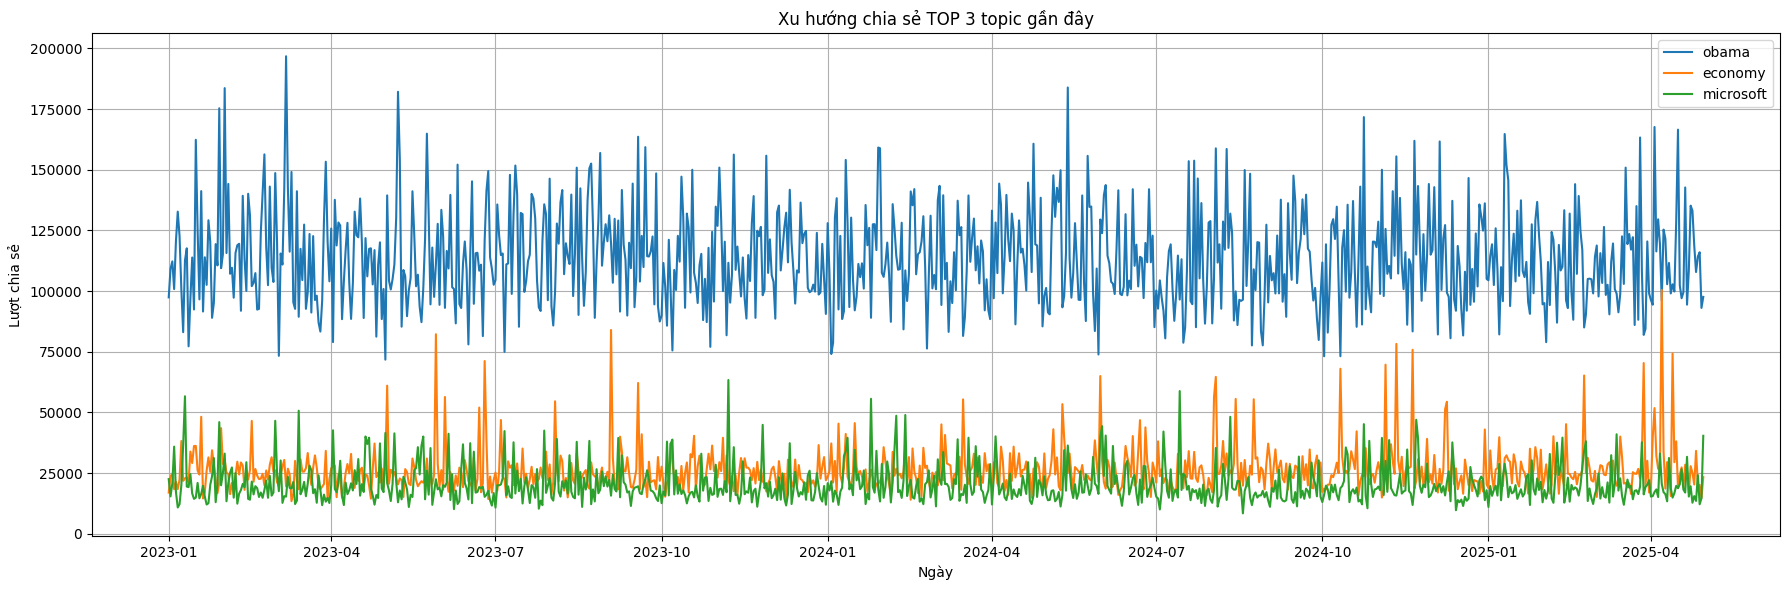

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))  # ✅ tăng chiều ngang

for topic in ['obama', 'economy', 'microsoft']:
    ts = df_daily[df_daily['Topic'] == topic]
    plt.plot(ts['PublishDate'], ts['TotalShare'], label=topic)

plt.title("Xu hướng chia sẻ TOP 3 topic gần đây")
plt.xlabel("Ngày")
plt.ylabel("Lượt chia sẻ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
from prophet import Prophet

topics = df['Topic'].unique()
results = []  # ← Danh sách lưu kết quả

for topic in topics:
    df_topic = df_daily[df_daily['Topic'] == topic].copy()
    if len(df_topic) < 30:
        continue  # bỏ qua topic ít dữ liệu

    df_prophet = df_topic.rename(columns={'PublishDate': 'ds', 'TotalShare': 'y'})

    model = Prophet(daily_seasonality=True)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=14)
    forecast = model.predict(future)

    total_forecast = int(forecast['yhat'][-14:].sum())

    # ⬇ Lưu kết quả vào danh sách
    results.append((topic, total_forecast))

    # In kết quả (nếu muốn)
    print(f"TOPIC: {topic} → Tổng dự báo 14 ngày: {total_forecast:,}")



DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv5tjfkr/6eon5edd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv5tjfkr/_0uttjm3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29783', 'data', 'file=/tmp/tmpbv5tjfkr/6eon5edd.json', 'init=/tmp/tmpbv5tjfkr/_0uttjm3.json', 'output', 'file=/tmp/tmpbv5tjfkr/prophet_modelqj7ucoli/prophet_model-20250522052527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:25:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:25:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv5tjfkr/m4oadxi8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv5tjfkr/bpfppyig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

TOPIC: obama → Tổng dự báo 14 ngày: 1,575,408


05:25:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv5tjfkr/79785fwz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv5tjfkr/nqi9un0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35493', 'data', 'file=/tmp/tmpbv5tjfkr/79785fwz.json', 'init=/tmp/tmpbv5tjfkr/nqi9un0d.json', 'output', 'file=/tmp/tmpbv5tjfkr/prophet_model4sdmnmp0/prophet_model-20250522052528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:25:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


TOPIC: economy → Tổng dự báo 14 ngày: 388,488


05:25:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv5tjfkr/uq9_ovg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv5tjfkr/dr8ki04m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88584', 'data', 'file=/tmp/tmpbv5tjfkr/uq9_ovg0.json', 'init=/tmp/tmpbv5tjfkr/dr8ki04m.json', 'output', 'file=/tmp/tmpbv5tjfkr/prophet_modelkdk6gfog/prophet_model-20250522052529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:25:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


TOPIC: microsoft → Tổng dự báo 14 ngày: 270,138


05:25:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TOPIC: palestine → Tổng dự báo 14 ngày: 74,164


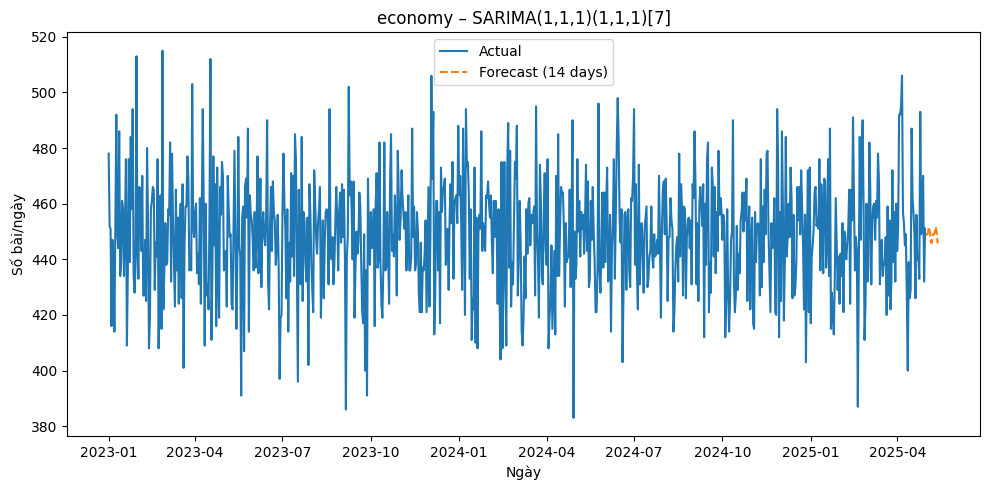

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from google.colab import drive # Import drive again if running this cell independently

# Kết nối Google Drive (chỉ cần chạy nếu chưa mount)
# drive.mount('/content/drive')

# --- Biểu đồ 1: topic đầu tiên ---
# 1. Load dữ liệu
# Sử dụng lại đường dẫn đầy đủ tới file trên Google Drive
file_path = '/content/drive/My Drive/10GB/news_extended_1gb_filtered.csv'

df = pd.read_csv(
    file_path,
    usecols=['PublishDate', 'Topic'],
    parse_dates=['PublishDate']
)
# 2. Chuẩn bị chuỗi thời gian số bài/ngày cho mỗi topic
df.set_index('PublishDate', inplace=True)
daily_counts = df.groupby('Topic').resample('D').size().unstack(level=0).fillna(0)

# 3. Chọn topic xếp thứ nhất
topic = daily_counts.sum().nlargest(3).index[0]
ts = daily_counts[topic]

# 4. Fit SARIMA và forecast 14 ngày
model = SARIMAX(
    ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
# Add a try-except block to handle potential convergence warnings or errors during fitting
try:
    result = model.fit(disp=False)
    forecast = result.get_forecast(steps=14)

    # 5. Vẽ biểu đồ
    plt.figure(figsize=(10, 5))
    plt.plot(ts.index, ts.values, label='Actual')
    plt.plot(
        forecast.predicted_mean.index,
        forecast.predicted_mean.values,
        linestyle='--', label='Forecast (14 days)'
    )
    plt.title(f'{topic} – SARIMA(1,1,1)(1,1,1)[7]')
    plt.xlabel('Ngày')
    plt.ylabel('Số bài/ngày')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error fitting SARIMA model for topic {topic}: {e}")
    print("Skipping plot for this topic.")

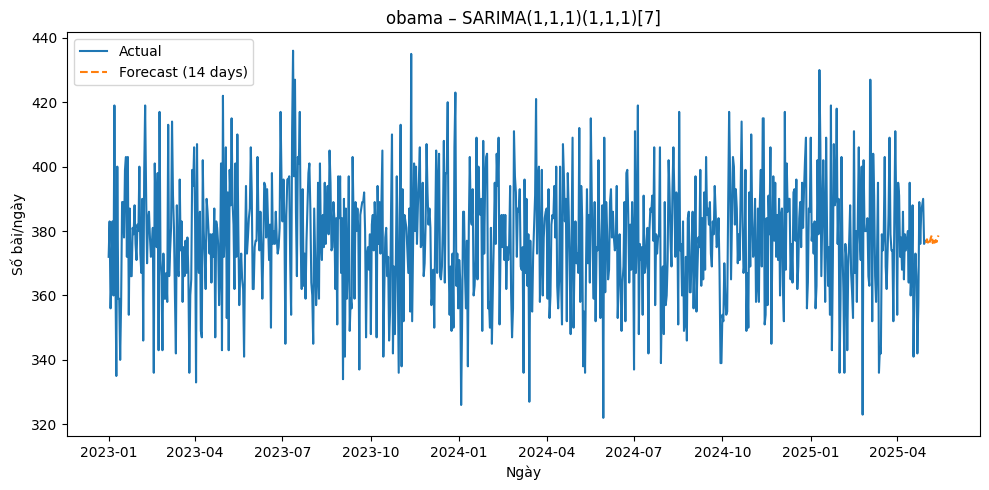

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Biểu đồ 2: topic thứ hai ---
# Sử dụng lại đường dẫn đầy đủ tới file trên Google Drive
file_path = '/content/drive/My Drive/10GB/news_extended_1gb_filtered.csv'

df = pd.read_csv(
    file_path, # Sử dụng đường dẫn đầy đủ
    usecols=['PublishDate', 'Topic'],
    parse_dates=['PublishDate']
)
df.set_index('PublishDate', inplace=True)
daily_counts = df.groupby('Topic').resample('D').size().unstack(level=0).fillna(0)

topic = daily_counts.sum().nlargest(3).index[1]
ts = daily_counts[topic]

model = SARIMAX(
    ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
try:
    result = model.fit(disp=False)
    forecast = result.get_forecast(steps=14)

    plt.figure(figsize=(10, 5))
    plt.plot(ts.index, ts.values, label='Actual')
    plt.plot(
        forecast.predicted_mean.index,
        forecast.predicted_mean.values,
        linestyle='--', label='Forecast (14 days)'
    )
    plt.title(f'{topic} – SARIMA(1,1,1)(1,1,1)[7]')
    plt.xlabel('Ngày')
    plt.ylabel('Số bài/ngày')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error fitting SARIMA model for topic {topic}: {e}")
    print("Skipping plot for this topic.")

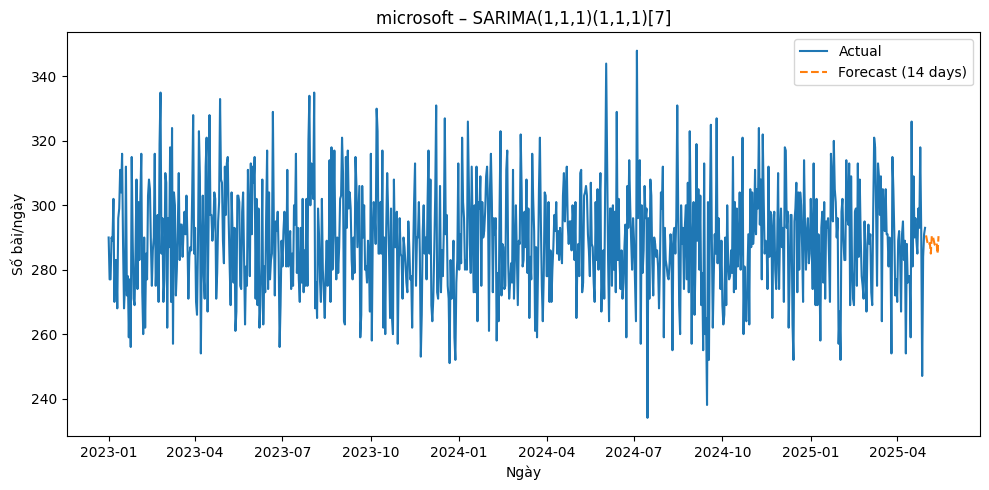

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from google.colab import drive # Import drive again if running this cell independently

# Kết nối Google Drive (chỉ cần chạy nếu chưa mount)
# drive.mount('/content/drive')

# --- Biểu đồ 3: topic thứ ba ---
# Sử dụng lại đường dẫn đầy đủ tới file trên Google Drive
file_path = '/content/drive/My Drive/10GB/news_extended_1gb_filtered.csv' # Define file_path again if running cell independently

df = pd.read_csv(
    file_path, # Use the file_path variable here
    usecols=['PublishDate', 'Topic'],
    parse_dates=['PublishDate']
)
df.set_index('PublishDate', inplace=True)
daily_counts = df.groupby('Topic').resample('D').size().unstack(level=0).fillna(0)

topic = daily_counts.sum().nlargest(3).index[2]
ts = daily_counts[topic]

model = SARIMAX(
    ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
# Add a try-except block to handle potential convergence warnings or errors during fitting
try:
    result = model.fit(disp=False)
    forecast = result.get_forecast(steps=14)

    plt.figure(figsize=(10, 5))
    plt.plot(ts.index, ts.values, label='Actual')
    plt.plot(
        forecast.predicted_mean.index,
        forecast.predicted_mean.values,
        linestyle='--', label='Forecast (14 days)'
    )
    plt.title(f'{topic} – SARIMA(1,1,1)(1,1,1)[7]')
    plt.xlabel('Ngày')
    plt.ylabel('Số bài/ngày')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error fitting SARIMA model for topic {topic}: {e}")
    print("Skipping plot for this topic.")

In [15]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We don't need to import drive again or mount it in this cell if it's already mounted in a previous cell

# 1. Load dữ liệu bao gồm cả các cột share count và topic
# Sử dụng lại đường dẫn đầy đủ tới file trên Google Drive
file_path = '/content/drive/My Drive/10GB/news_extended_1gb_filtered.csv'

# Change usecols to include the columns needed to calculate TotalShare
df = pd.read_csv(
    file_path,
    usecols=['PublishDate', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn'], # Include columns needed for TotalShare
    parse_dates=['PublishDate']
)

# 2. Đặt index về ngày
df.set_index('PublishDate', inplace=True)

# 3. Thay -1 (mất dữ liệu mạng xã hội) bằng 0 (Assuming this cleaning is still needed for share counts)
df[['Facebook', 'GooglePlus', 'LinkedIn']] = df[['Facebook', 'GooglePlus', 'LinkedIn']].replace(-1, 0)

# 4. Tính cột TotalShare
df['TotalShare'] = df[['Facebook', 'GooglePlus', 'LinkedIn']].sum(axis=1)


# 5. Các topic cần forecast
topics = ['obama', 'economy', 'microsoft']

for topic in topics:
    # 6. Tạo chuỗi daily sum của TotalShare
    # Use 'TotalShare' column for aggregation
    ts_share = (
        df[df['Topic'] == topic]
        .resample('D')['TotalShare'] # Aggregate 'TotalShare'
        .sum()
        .fillna(0)
    )

    # Add a check to ensure the time series is not empty
    if ts_share.empty:
        print(f"TOPIC: {topic} -> Không có dữ liệu share_count.")
        continue # Skip to the next topic

    # 7. Fit SARIMA(1,1,1)(1,1,1)[7]
    model = SARIMAX(
        ts_share,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    # Add a try-except block to handle potential convergence warnings or errors during fitting
    try:
        res = model.fit(disp=False)

        # 8. Dự báo 14 ngày và tính tổng
        forecast = res.get_forecast(steps=14).predicted_mean
        total_share = forecast.sum()

        # 9. In ra kết quả format với dấu phẩy phân nghìn
        print(f"TOPIC: {topic} -> Tổng dự báo 14 ngày: {total_share:,.0f}")
    except Exception as e:
        print(f"Error fitting SARIMA model for topic {topic}: {e}")
        print("Skipping forecast for this topic.")

TOPIC: obama -> Tổng dự báo 14 ngày: 1,483,912
TOPIC: economy -> Tổng dự báo 14 ngày: 387,696
TOPIC: microsoft -> Tổng dự báo 14 ngày: 277,552
